<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_11_04_text_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [6]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import numpy as np
import random
import sys
import io
import requests
import re
import pandas 
import  eng_to_ipa as phon

In [7]:
#voir Beatles Analysis pour la source de ces textes

with open('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/last_words.txt', 'r') as file:
    last_words = file.read()
with open('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/lyricsnoskipline.txt', 'r') as file: # sans skiplines
    fulltext2 = file.read()  
with open('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/fullchords.txt', 'r') as file:
    fullchords = file.read() 
with open('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/lyricsskipline.txt', 'r') as file: #avec skiplines
    fulltext = file.read() 
    
    
len(fulltext)

214536

## TOKENISATION

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(fulltext)
vocab = set()
tokenized_text = []

for token in doc:
    word = ''.join([i for i in token.text])
    word = word.strip()
    vocab.add(word)
    tokenized_text.append(word)
        
print(f"Vocab size: {len(vocab)}")

Vocab size: 2236


In [11]:
word2idx = dict((n, v) for v, n in enumerate(vocab))
idx2word = dict((n, v) for n, v in enumerate(vocab))


In [12]:
tokenized_text = [word2idx[word] for word in tokenized_text]

In [13]:
type(tokenized_text[1])

int

In [14]:
# séparer le texte en séquence de longueur maxlen
maxlen = 12
step = 4
sentences = []
next_words = []
for i in range(0, len(tokenized_text) - maxlen, step):
    sentences.append(tokenized_text[i: i + maxlen])
    next_words.append(tokenized_text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 10418


In [15]:
print(len(sentences),len(sentences[1]))


10418 12


In [16]:
#on vectorize notre liste
print ('Vectorization...')
x=np.asarray(sentences)


y=np.asarray(next_words, order='F')
print (type(x), type(sentences), x.shape, y.shape)
y

Vectorization...
<class 'numpy.ndarray'> <class 'list'> (10418, 12) (10418,)


array([  53, 1152,   96, ..., 1017, 2014,  118])

In [17]:
#fonction pour extraire la dernière syllabe

def last_syl(phone):
    vowels=['i', 'ɪ', 'e', 'ɛ', 'æ', 'a', 'ə', 'ɑ', 'ɒ', 'ɔ', 'ʌ', 'o', 'ʊ', 'u', 'y', 'ʏ', 'ø', 'œ', 'ɐ', 'ɜ', 'ɞ', 'ɘ', 'ɵ', 'ʉ', 'ɨ', 'ɤ', 'ɯ']   
    n=1
    while (n+1<len(phone)) and (phone[-n] not in vowels):
        n+=1
    if n+1<len(phone):
        if phone[-(n+1)] in vowels:
            n+=1
    sy=re.sub('[!@#$.)"*(]', '', a[-n:])
    return sy

In [18]:
#ajouter la dimension de rimes au word embedding
i=0
wordidx=[]
pword=[]
psyl=[]
v=list(vocab)
while i<len(v):
    a=phon.convert(v[i])
    wordidx.append(word2idx[v[i]])
    pword.append(a)
    psyl.append(last_syl(a))
    i+=1
len(v), len(pword), len(psyl), len(wordidx)

dfrhymes=pandas.DataFrame({'index': wordidx, 'mot':v, 'phonetic':pword, 'syl':psyl})
dfrhymes

,index,mot,phonetic,syl
0,0,,,
1,1,whacking,ˈwækɪŋ,ɪŋ
2,2,spending,ˈspɛndɪŋ,ɪŋ
3,3,thirty,ˈθərˌdi,i
4,4,kill,kɪl,ɪl
...,...,...,...,...
2231,2231,brew,bru,u
2232,2232,latest,ˈleɪtəst,əst
2233,2233,benefit,ˈbɛnəfɪt,ɪt
2234,2234,sea,si,i


In [19]:
#conversion du df en vecteur catégoriel
rr = np.array(dfrhymes['syl'])

le = LabelEncoder()

rr=le.fit_transform(rr)
rr = to_categorical(rr)

rr.shape


(2236, 505)

In [34]:
print ('Importation du GLOVE Embedding...')
j=0
embedding_vector = {}
glove = open('C:/Users/benoi/Documents/HEC/_Hiver 2021/Machine Learning/projet/glove.6B.300d.txt', encoding="utf8")
for line in glove:
    a = line.split(' ')
    word = a[0]
    coef = np.array(a[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((len(vocab),300))
for word,i in word2idx.items():
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value
    else:
        j+=1
        
print(embedding_matrix.shape, j, 'mots non trouvés dans GLOVE, pourcentage: ', j/embedding_matrix.shape[0])
embedding_matrix

Importation du GLOVE Embedding...
(2236, 300) 65 mots non trouvés dans GLOVE, pourcentage:  0.029069767441860465


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54377002, -0.040027  , -0.36065999, ..., -0.3608    ,
         0.68027002, -0.63621002],
       [-0.35767999,  0.22554   ,  0.43713999, ...,  0.45666   ,
         0.30069   ,  0.071586  ],
       ...,
       [ 0.12173   , -0.52783   , -0.32065001, ...,  0.066712  ,
        -0.07923   ,  0.20037   ],
       [-0.49875   ,  0.45581999, -0.15914001, ..., -0.2325    ,
         0.29359999,  0.25839999],
       [-0.052904  , -0.52214998,  0.61027998, ...,  0.10879   ,
         0.24323   ,  0.48824999]])

In [35]:
embedding_matrix_rhymes= np.concatenate((embedding_matrix,rr),axis=1)#on combine les deux matrices

In [36]:
embedding_matrix_rhymes.shape

(2236, 805)

In [37]:
x.shape

(10418, 12)

In [38]:
y.shape

(10418,)

Because we encoded the $y$ value o dummy variables we can see, there are 6,418 elements for each row of $y$.  This large number of elements is because there are 6,418 words in the vocabulary.  Large vocabularies can significantly increase the amount of memory needed.

In [20]:
model = keras.models.load_model('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/MODEL')

In [39]:
#Modèle
model = Sequential()
model.add(Embedding(len(vocab), 805, input_length=maxlen,  weights = [embedding_matrix_rhymes], trainable = False ))
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.5,  recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(len(vocab), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 805)           1799980   
_________________________________________________________________
bidirectional (Bidirectional (None, 12, 512)           2174976   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 12, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 2236)              574652    
Total params: 5,600,232
Trainable params: 3,800,252
Non-trainable params: 1,799,980
_________________________________________________________________


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 805)           1799980   
_________________________________________________________________
bidirectional (Bidirectional (None, 12, 512)           2174976   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 12, 256)           656384    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 2236)              574652    
Total params: 5,600,232
Trainable params: 5,600,232
Non-trainable params: 0
_________________________________________________________________


In [21]:
###### apprentissage
model.fit(x, y,
         batch_size=100,
          epochs=1, verbose=1)

105/105 [==============================] - 146s 968ms/step - loss: 7.5182 - accuracy: 0.0940


In [56]:
model.save('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/MODEL')

INFO:tensorflow:Assets written to: C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/MODEL\assets


In [117]:
model.fit(x, y,
         batch_size=100,
          epochs=3, verbose=1)

Epoch 1/3
105/105 [==============================] - 288s 3s/step - loss: 0.2347 - accuracy: 0.9304
Epoch 2/3
105/105 [==============================] - 288s 3s/step - loss: 0.2449 - accuracy: 0.9292
Epoch 3/3
105/105 [==============================] - 304s 3s/step - loss: 0.2347 - accuracy: 0.9319


In [50]:
history2 = model.fit(x, y,
         batch_size=200,
          epochs=50, verbose=1)

Epoch 1/50
53/53 [==============================] - 81s 1s/step - loss: 0.3897 - accuracy: 0.8973
Epoch 2/50
53/53 [==============================] - 82s 2s/step - loss: 0.3921 - accuracy: 0.8975
Epoch 3/50
53/53 [==============================] - 78s 1s/step - loss: 0.3866 - accuracy: 0.9019
Epoch 4/50
53/53 [==============================] - 78s 1s/step - loss: 0.3976 - accuracy: 0.8983
Epoch 5/50
53/53 [==============================] - 81s 2s/step - loss: 0.3659 - accuracy: 0.9085
Epoch 6/50
53/53 [==============================] - 81s 2s/step - loss: 0.3797 - accuracy: 0.9042
Epoch 7/50
53/53 [==============================] - 78s 1s/step - loss: 0.3657 - accuracy: 0.9033
Epoch 8/50
53/53 [==============================] - 79s 1s/step - loss: 0.3649 - accuracy: 0.9051
Epoch 9/50
53/53 [==============================] - 79s 1s/step - loss: 0.3621 - accuracy: 0.9088
Epoch 10/50
53/53 [==============================] - 78s 1s/step - loss: 0.3622 - accuracy: 0.9053
Epoch 11/50
53/53 [

In [47]:
history1.history['accuracy']

[0.7684776186943054,
 0.7726051211357117,
 0.7779804468154907,
 0.7799961566925049,
 0.774716854095459,
 0.789402961730957,
 0.7929545044898987,
 0.7916106581687927,
 0.798713743686676,
 0.801113486289978,
 0.8058168292045593,
 0.8119600415229797,
 0.8048569560050964,
 0.8174313902854919,
 0.8166634440422058,
 0.8200230598449707,
 0.8261662721633911,
 0.8270301222801208,
 0.8228066563606262,
 0.830773651599884,
 0.8355730175971985,
 0.835093080997467,
 0.8397964835166931,
 0.8489153385162354,
 0.8451718091964722,
 0.846419632434845,
 0.858802080154419,
 0.8539066910743713,
 0.8542906641960144,
 0.8576502203941345,
 0.8583221435546875,
 0.8552505373954773,
 0.8667690753936768,
 0.8711844682693481,
 0.8710885047912598,
 0.8704165816307068,
 0.8764638304710388,
 0.8742560744285583,
 0.8828949928283691,
 0.8773276805877686,
 0.8770397305488586,
 0.8806872963905334,
 0.8848147392272949,
 0.8840468525886536,
 0.8875983953475952,
 0.8851026892662048,
 0.8892301917076111,
 0.8900940418243408,


In [51]:
precision_historique+=history2.history['accuracy']
len(precision_historique)

200

NameError: name 'precision_historique' is not defined

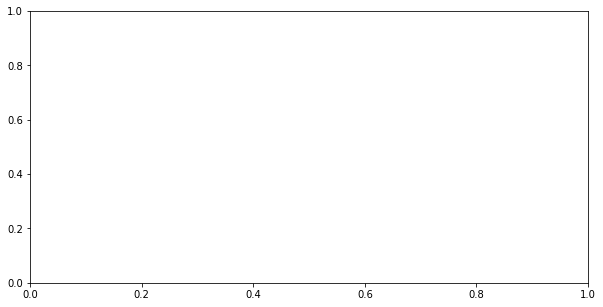

In [2]:
import matplotlib.pyplot as plt 
fig,ax =plt.subplots()
fig.set_size_inches(10,5)
plt.plot(precision_historique)

plt.title("Précision de notre modèle en fonction du nombre d'itérations")
plt.ylabel('Précision')
plt.xlabel('Itérations')
plt.show()
#fig.savefig("nlp1.jpg")

In [61]:
#fonction trouvé sur https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_11_04_text_nlp.ipynb

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [59]:
a='I love the'
b='If you are'
c='The way you'
d='Do you know'
e='If I'
f="I do n't think you should"
g='Why'
h='What do you'
i='I'   
j='endofsong'
k='She'
text_starters=[a,b,c,d,e,f,g,h,i,j,k]

In [376]:
gensongs=pandas.DataFrame({'Datetime':time, 'Temperature': temper, 'Paroles':chansons})
#gensongs.to_csv( 'C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/Songs_generated.txt', mode='a', header=False)


,Datetime,Temperature,Paroles
0,2021-04-10 19:34:26.252085,0.4,endofsong endofsong endofsong bird trust there...
1,2021-04-10 19:44:27.033338,0.8,endofsong \n stream trust there there all all ...
2,2021-04-10 19:54:08.168835,1.2,endofsong endofsong endofsong m'bop act toweri...
3,2021-04-10 20:04:48.824885,0.4,I do n't think you should ran there there to h...
4,2021-04-10 20:15:54.324445,0.8,I do n't think you should ran there there to g...
5,2021-04-10 20:26:44.361215,1.2,I do n't think you should ran there there ca n...
6,2021-04-10 20:37:20.505270,0.4,If you are endofsong endofsong act there there...
7,2021-04-10 20:48:58.893926,0.8,If you are endofsong there there there long co...
8,2021-04-10 21:04:01.417239,1.2,If you are now endofsong endofsong endofsong b...
9,2021-04-10 21:18:18.842752,0.4,endofsong endofsong endofsong bird act there t...


In [4]:



from datetime import datetime

def writelyrics(seed_text, nb_words, temp=0.8):#fonction pour générer du texte
    print(nb_words, 'mots générés à partir du texte: ', seed_text)
    j=0
    time=[]
    temper=[]
    chansons=[]
   
    while j < nb_words:
        sentence = seed_text.lower()
        sentence=sentence.split(' ')
        i=0
        token_list=[]
        while i<len(sentence):
            token_list.append(word2idx[sentence[i]])#dictionnaire pour convertir le mot en index
            i+=1
        token_list = pad_sequences([token_list],# on pad la séquence
                     maxlen=maxlen,padding='pre')
        a = model.predict(token_list)#prediction du mot suivant
        a=a[0, :]
        next_index = sample(a, temperature=temp)
        next_word = idx2word[next_index]#conversion index en mot
        print(next_word)
        
        seed_text += " " + next_word#on ajoute à la liste
        j+=1
        
    seed_text+= 'skiplines'#on ajoute le texte dans un fichier csv avec l'heure et la température
    a=seed_text.replace('skiplines', '\n')
    time.append(datetime.now())
    temper.append(temp)
    chansons.append(a)
    gensongs=pandas.DataFrame({'Datetime':time, 'Temperature': temper, 'Paroles':chansons}) 
    gensongs.to_csv('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/Songs_generated.txt',
                    mode='a', header=False)  
    bob=seed_text
    print (bob)
    print('----------------------------')
    

def build_df(nb_texts, nb_words):
    i=0
    while i<nb_texts:
        #model.fit(x, y, batch_size=100, epochs=2, verbose=1)
        r=random.randint(0, len(text_starters)-1)
        s=text_starters[r]   
        writelyrics(s, nb_words, temp=0.7)
        writelyrics(s, nb_words, temp=1)
        writelyrics(s, nb_words, temp=1.2)
        i+=1   
    
    
    
    
    
    
    

def generatelyrics(seed_text, nb_words, temp=0.8, nb_lines=10):
    print(nb_words, 'mots générés à partir du texte: ', seed_text)
    j=0
    while j < nb_words:
        a = seed_text.lower()
        sentence=a.split(' ')
        i=0
        token_list=[]
        while i<len(sentence):
            token_list.append(word2idx[sentence[i]])
            i+=1
        token_list = pad_sequences([token_list],
                     maxlen=maxlen,padding='pre')
        a = model.predict(token_list)
        a=a[0, :]
        next_index = sample(a, temperature=temp)
        next_word = idx2word[next_index]
        print(next_word)
        seed_text += " " + next_word
        j+=1

        
    bob=seed_text
    print (bob)
    print('----------------------------')  





In [119]:

def build_df(nb_texts, nb_words):
    i=0
    while i<nb_texts:
        model.fit(x, y, batch_size=100, epochs=2, verbose=1)
        r=random.randint(0, len(text_starters)-1)
        s=text_starters[r]   
        writelyrics(s, nb_words, temp=0.4)
        writelyrics(s, nb_words, temp=0.8)
        writelyrics(s, nb_words, temp=1.2)
        i+=1



We will now fit the model. As the model fits, we display sample text that the model is generating.  We display text at several "temperatures." For this example, temperature refers to the amount of randomness allowed in words chosen by the neural network.

In [100]:
r=random.randint(0, len(text_starters)-1)
s=text_starters[r] 
generatelyrics(s, 50)

50 mots générés à partir du texte:  If you are
a
dove
with
the
bags
but
won
skiplines
but
i
told
that
we
notice
the
end
of
90
skiplines
and
i
get
home
skiplines
we
're
on
our
way
home
skiplines
we
're
down
and
wondering
from
you
and
i
'll
forgive
you
skiplines
let
me
love
me
skiplines
you
If you are a dove with the bags but won skiplines but i told that we notice the end of 90 skiplines and i get home skiplines we 're on our way home skiplines we 're down and wondering from you and i 'll forgive you skiplines let me love me skiplines you
----------------------------


In [3]:
build_df(1,100)

NameError: name 'build_df' is not defined

In [ ]:
build_df(8,100)

## Ceci est un modele assez similaire, mais pour générer des accords. Nous l'avons copié à partir du même endroit que pour la fonction de sample, nous ne l'avons pas utilisé finalement

In [301]:
# import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(fullchords)
vocabc = set()
tokenized_chord = []

for token in doc:
    word = ''.join([i for i in token.text])
    word = word.strip()
    vocabc.add(word)
    tokenized_chord.append(word)
        
print(f"Vocab size: {len(vocabc)}")

print(list(vocab)[1:5])

#We need an easy way to convert words into indexes and vise versa. The following code builds two such indexes.

chord2idx = dict((n, v) for v, n in enumerate(vocabc))
idx2chord = dict((n, v) for n, v in enumerate(vocabc))

#We can now tokenize the text; this process replaces each word with the correct token.

tokenized_chord = [chord2idx[word] for word in tokenized_chord]

#If we display the tokenized text, we see an array of index values for each word.

print(tokenized_chord)

#Next, we break the tokenized text into sequences that are of consistent length.  It is necessary to specify this length; here we use a sequence length of 6.

# cut the text in semi-redundant sequences of maxlen words
maxlen1 = 8
step1 = 3
sentences1 = []
next_words1 = []
for i in range(0, len(tokenized_chord) - maxlen1, step1):
    sentences1.append(tokenized_chord[i: i + maxlen1])
    next_words1.append(tokenized_chord[i + maxlen1])
print('nb sequences:', len(sentences1))

#We can display the first five sequences to get an idea of the appearance of the data.

#sentences[0:5]

#Finally, we create the $x$ and $y$ vectors.  The $x$ is a Numpy encoding of the tokenization that we just performed.  We use the first six elements of each tokenization to predict the seventh element.  We convert the next element to dummy variables, and it becomes the $y$.  For each of the sequences, we teach the neural network to predict the sixth element (or word) based on the previous five elements.

import numpy as np

print('Vectorization...')
x1 = np.zeros((len(sentences1), maxlen1, len(vocabc)), dtype=np.bool)
y1 = np.zeros((len(sentences1), len(vocabc)), dtype=np.bool)
for i, sentence1 in enumerate(sentences1):
    for t, word1 in enumerate(sentence1):
        x1[i, t, word1] = 1
    y1[i, next_words1[i]] = 1

#We display the shapes of the $x$ and $y$.

print(x1.shape)

print(y1.shape)


y[0:5]


#Now we can train an LSTM-based neural network to generate text.

# build the model: a single LSTM
print('Build model...')
modelc = Sequential()
modelc.add(LSTM(250, input_shape=(maxlen1, len(vocabc)), return_sequences=True ))
modelc.add(Dropout(0.3))
modelc.add(LSTM(250, input_shape=(maxlen1, len(vocabc))))
modelc.add(Dense(len(vocabc), activation='softmax'))

optimizer = RMSprop(lr=0.01)
modelc.compile(loss='categorical_crossentropy', optimizer='Adam')

print(modelc.summary())

#This function collects sample generations from the neural network.  The temperature variable specifies how conservative, or less random, the predictions will be.  Higher temperatures encourage more "creativity" from the neural network; however, they also promote more nonsensical output.

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#Keras calls the following function at the end of each training Epoch.  The code generates sample text generations that visually demonstrate the neural network better at text generation.  As the neural network trains, the generations should look more realistic.

def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print("******************************************************")
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(tokenized_chord) - 3)
    for temperature in [0.6, 1, 1.2]:
        print('----- temperature:', temperature)

        #generated = ''
        sentencet = tokenized_chord[start_index: start_index + 3]
        #generated += sentencet
        o = ' '.join([idx2chord[idx] for idx in sentencet])
        print(f'----- Generating with seed: "{o}"')
        #sys.stdout.write(generated)

        for i in range(20):
            x_pred = np.zeros((1, maxlen1, len(vocabc)))
            for t, word in enumerate(sentencet):
                x_pred[0, t, word] = 1.
                

            preds = modelc.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_word = idx2chord[next_index]

            #generated += next_char
            sentencet = sentencet[1:]
            sentencet.append(next_index)

            sys.stdout.write(next_word)
            sys.stdout.write(' ') 
            sys.stdout.flush()
        print()


#We will now fit the model. As the model fits, we display sample text that the model is generating.  We display text at several "temperatures." For this example, temperature refers to the amount of randomness allowed in words chosen by the neural network.

print (chord2idx['I'], chord2idx['i'])
print (x1.shape, y1)


Vocab size: 158
['wandering', 'leg', 'say', 'tonight']
[0, 60, 87, 65, 118, 60, 87, 65, 118, 60, 87, 80, 118, 25, 141, 137, 40, 141, 130, 141, 137, 25, 141, 54, 141, 54, 141, 54, 141, 91, 94, 91, 124, 78, 130, 31, 130, 78, 124, 91, 94, 91, 141, 124, 91, 141, 124, 118, 25, 60, 91, 40, 60, 91, 40, 60, 118, 25, 60, 15, 136, 53, 40, 136, 118, 113, 83, 68, 107, 40, 76, 120, 40, 82, 76, 120, 155, 53, 135, 113, 83, 68, 107, 40, 82, 76, 120, 155, 53, 118, 25, 113, 155, 118, 50, 113, 78, 85, 108, 110, 113, 155, 118, 50, 113, 55, 85, 108, 110, 40, 91, 110, 25, 113, 107, 80, 117, 53, 50, 53, 91, 45, 113, 107, 113, 107, 80, 74, 117, 74, 53, 50, 53, 50, 14, 33, 137, 53, 151, 53, 33, 42, 33, 96, 4, 96, 33, 42, 92, 78, 14, 33, 110, 121, 110, 91, 94, 91, 80, 51, 108, 91, 94, 91, 80, 117, 80, 53, 50, 53, 91, 118, 25, 60, 58, 87, 40, 41, 126, 128, 60, 65, 87, 84, 40, 93, 87, 84, 40, 93, 87, 40, 118, 60, 93, 111, 93, 111, 93, 60, 77, 68, 36, 118, 60, 77, 68, 36, 118, 60, 77, 68, 36, 60, 77, 68, 36, 60, 7

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 8, 250)            409000    
_________________________________________________________________
dropout_22 (Dropout)         (None, 8, 250)            0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 250)               501000    
_________________________________________________________________
dense_34 (Dense)             (None, 158)               39658     
Total params: 949,658
Trainable params: 949,658
Non-trainable params: 0
_________________________________________________________________
None
60 113
(1010, 8, 158) [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False

In [302]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

modelc.fit(x1, y1,
          batch_size=10,
          epochs=5,
          callbacks=[print_callback])

Epoch 1/5
101/101 [==============================] - 25s 102ms/step - loss: 4.3212
******************************************************
----- Generating text after Epoch: 0
----- temperature: 0.6
----- Generating with seed: "V7 i iv"
IV I ENDOFSONG IV IV IV V vi7 IV IV vi ENDOFSONG I IV V V V IV IV vi 
----- temperature: 1
----- Generating with seed: "V7 i iv"
IV I ENDOFSONG ii7 IV VI ii7 V7 iv64 IV6 VI64 IV42 V7 bIII V IV7 IV I I64 I42 
----- temperature: 1.2
----- Generating with seed: "V7 i iv"
V64 III bIII IV IV ii42 VI7 I bVI7 V7 VI43 IV V7 ii64 vii7 V7 I I6 I V43 
Epoch 2/5
101/101 [==============================] - 11s 105ms/step - loss: 3.6351
******************************************************
----- Generating text after Epoch: 1
----- temperature: 0.6
----- Generating with seed: "I V7 IV"
III IV ENDOFSONG V vi V IV IV I I IV I V vi vi7 V bVII V7 ENDOFSONG I 
----- temperature: 1
----- Generating with seed: "I V7 IV"
II bII I IV vi6 V43 bVI7 V65 ENDOFSONG i64 II V64 vi64 

In [ ]:
# import spacy
def prepare_str()
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(fullchords)
    vocabc = set()
    tokenized_chord = []

    for token in doc:
        word = ''.join([i for i in token.text])
        word = word.strip()
        vocabc.add(word)
        tokenized_chord.append(word)

    print(f"Vocab size: {len(vocabc)}")

    print(list(vocab)[1:5])

    #We need an easy way to convert words into indexes and vise versa. The following code builds two such indexes.

    chord2idx = dict((n, v) for v, n in enumerate(vocabc))
    idx2chord = dict((n, v) for n, v in enumerate(vocabc))

    #We can now tokenize the text; this process replaces each word with the correct token.

    tokenized_chord = [chord2idx[word] for word in tokenized_chord]

    #If we display the tokenized text, we see an array of index values for each word.

    print(tokenized_chord)

    #Next, we break the tokenized text into sequences that are of consistent length.  It is necessary to specify this length; here we use a sequence length of 6.

    # cut the text in semi-redundant sequences of maxlen words
    maxlen1 = ml
    step1 = s
    sentences1 = []
    next_words1 = []
    for i in range(0, len(tokenized_chord) - maxlen1, step1):
        sentences1.append(tokenized_chord[i: i + maxlen1])
        next_words1.append(tokenized_chord[i + maxlen1])
    print('nb sequences:', len(sentences1))

    #We can display the first five sequences to get an idea of the appearance of the data.

    #sentences[0:5]

    #Finally, we create the $x$ and $y$ vectors.  The $x$ is a Numpy encoding of the tokenization that we just performed.  We use the first six elements of each tokenization to predict the seventh element.  We convert the next element to dummy variables, and it becomes the $y$.  For each of the sequences, we teach the neural network to predict the sixth element (or word) based on the previous five elements.

    import numpy as np

    print('Vectorization...')
    x1 = np.zeros((len(sentences1), maxlen1, len(vocabc)), dtype=np.bool)
    y1 = np.zeros((len(sentences1), len(vocabc)), dtype=np.bool)
    for i, sentence1 in enumerate(sentences1):
        for t, word1 in enumerate(sentence1):
            x1[i, t, word1] = 1
        y1[i, next_words1[i]] = 1

    #We display the shapes of the $x$ and $y$.

    print(x1.shape)

    print(y1.shape)


    y[0:5]


#Now we can train an LSTM-based neural network to generate text.

# build the model: a single LSTM
print('Build model...')
modelc = Sequential()
modelc.add(LSTM(250, input_shape=(maxlen1, len(vocabc)), return_sequences=True ))
modelc.add(Dropout(0.3))
modelc.add(LSTM(250, input_shape=(maxlen1, len(vocabc))))
modelc.add(Dense(len(vocabc), activation='softmax'))

optimizer = RMSprop(lr=0.01)
modelc.compile(loss='categorical_crossentropy', optimizer='Adam')

print(modelc.summary())

#This function collects sample generations from the neural network.  The temperature variable specifies how conservative, or less random, the predictions will be.  Higher temperatures encourage more "creativity" from the neural network; however, they also promote more nonsensical output.

